In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:

#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/dtTests/'
TsecData = ['0-015.csv','0-03.csv','0-05.csv','0-075.csv','0-1.csv','0-15.csv','0-2.csv']

In [3]:
#here we will specify the features we will use
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tsec']

In [4]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [5]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [6]:
def getPerformance(datasheet):
    #we will first read the specified datasheet
    dataset = pd.read_csv(datasheet)
    dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1']) #we will drop junk columns
    #we can now split up the data into training and testing
    trainX, trainY, testX, testY = train_test(dataset, features)
    #define the dataset specific stable/unstable ratio
    trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]
    # we will define a new XGBoost model using the parameters found for the normal integrations
    model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )
    #we can now fit the model to training data
    model.fit(trainX,trainY)
    #determine the performance data
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)
    #we will next determine the FPR when our TPR is 0.9
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    falsePos = fpr[tprthreshindex]
    #return AUC and FPR
    return roc_auc,falsePos

In [7]:
%%time
dtList = [0.015,0.03,0.05,0.075,0.1,0.15, 0.2]
times = [84.3,44.5, 28.33, 20.1, 16,11, 6.66]
TsecAUC = []
TsecFPR = []
twoTsecAUC = []
twoTsecFPR = []
#iterate through all Tsec data
for path in TsecData:
    auc,fpr = getPerformance(datapath+path)
    TsecAUC.append(auc)
    TsecFPR.append(fpr)


CPU times: user 7min 41s, sys: 12.3 s, total: 7min 53s
Wall time: 7.8 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


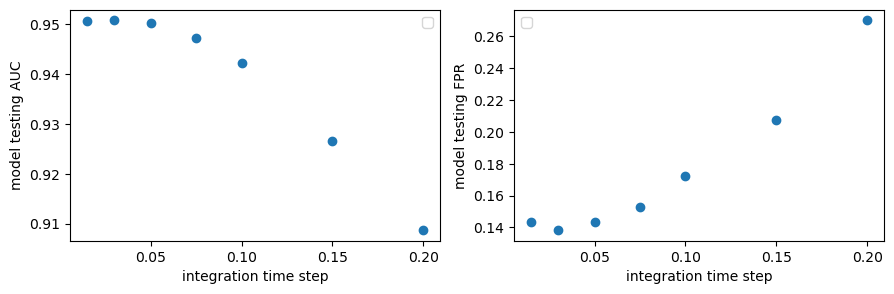

In [10]:
#We can plot our results
fig, (ax1, ax2) = plt.subplots(1, 2) 
ax1.scatter(dtList, TsecAUC, label='_Intigrated to 1Tsec')
ax1.set_xlabel('integration time step')
ax1.set_ylabel('model testing AUC')
ax1.legend()
ax2.scatter(dtList, TsecFPR,  label='_Intigrated to 1Tsec')
ax2.set_xlabel('integration time step')
ax2.set_ylabel('model testing FPR')
ax2.legend()
fig.set_figheight(3)
fig.set_figwidth(10.5)

